## Zillow Housing Forecasting

#### Author: Kyle Dufrane

## Business Understanding:

#### Our stakeholder is a national real estate firm that is looking to invest in the current housing market. They're looking for the top 5 most profitable zip codes from the past 10 years in NY State. 

## Data Understanding

In [1]:
# !pip install plotly
# !pip install ipywidgets

In [2]:
import pickle
import plotly
import ipywidgets
import pystan
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly


# from pmdarima import auto_arima

sns.set_style('darkgrid')
pd.set_option('display.max_columns', 999)

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, 'src/')
import functions

In [3]:
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon_1.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,190326.0,189141.0,189204.0,189184.0,189617.0,190143.0,190050.0,190716.0,191006.0,192332.0,193351.0,194629.0,195822.0,198184.0,199522.0,200279.0,200960.0,201676.0,203826.0,204267.0,205610.0,205330.0,206963.0,209099.0,211915.0,214608.0,218032.0,221994.0,225131.0,228437.0,230544.0,234624.0,238545.0,243892.0,246984.0,249192.0,251478.0,253822.0,256305.0,258086.0,261583.0,265795.0,272467.0,278865.0,286053.0,292290.0,299184.0,306010.0,311352.0,317402.0,323472.0,331723.0,339181.0,346161.0,3

In [4]:
df.columns[:11]

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '1996-01-31', '1996-02-29'],
      dtype='object')

#### This dataset comes from [Zillow Research](https://www.zillow.com/research/data/). The dataset selected is labeled 'ZHVI All Homes (SFR, Condo/Co-op) Time Series, Smoothed, Seasonally Adjusted' filtered by Zip Code.

#### As we can see in the cell above our dataset contains nine columns followed by 305 columns with home values by date. 

#### To start understanding out data, we will identify what each of the first nine columns mean below: 

* RegionID: Based on my research this seems to be Zillow specific.
* SizeRank: Further analysis is needed. 
* RegionName: Zipcode
* RegionType: Denotes region type - I.E. RegionName = Zipcode
* StateName: U.S. State 
* State: U.S. State 
* City: City associated to zipcode
* Metro: Metroplitian Area
* CountyName: name of the county the zipcode resides in

#### At first glance, it looks like these values are at the end of each month starting on January 31st, 1996 and ending on May 31st, 2021. Since our stakeholder is only concerned with the past 10 years we will filter our date columns to January 2011 until present. In Zillows summary they state that these values are representative of a 'typical home value'. They do not elaborate further on their definition. Moving forward we will assume that this is the mean price for all homes within a given zip code. 

#### To start we will filter our data by state and bein to get a more indepth look into our data, lets see if we can get a clearer picture on what SizeRank denotes in our dataset. 

In [5]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,190326.0,189141.0,189204.0,189184.0,189617.0,190143.0,190050.0,190716.0,191006.0,192332.0,193351.0,194629.0,195822.0,198184.0,199522.0,200279.0,200960.0,201676.0,203826.0,204267.0,205610.0,205330.0,206963.0,209099.0,211915.0,214608.0,218032.0,221994.0,225131.0,228437.0,230544.0,234624.0,238545.0,243892.0,246984.0,249192.0,251478.0,253822.0,256305.0,258086.0,261583.0,265795.0,272467.0,278865.0,286053.0,292290.0,299184.0,306010.0,311352.0,317402.0,323472.0,331723.0,339181.0,346161.0,3

In [6]:
df = df[df['State'] == 'NY']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754 entries, 0 to 30823
Columns: 314 entries, RegionID to 2021-05-31
dtypes: float64(305), int64(3), object(6)
memory usage: 4.2+ MB


In [8]:
df[df['SizeRank'] == 29685].head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
27746,63115,29685,13435,Zip,NY,NY,Prospect,Utica-Rome,Oneida County,113396.0,111930.0,111365.0,109862.0,109148.0,108962.0,108418.0,107911.0,105338.0,103873.0,102074.0,102033.0,102489.0,105524.0,107995.0,111158.0,111000.0,109111.0,106176.0,103825.0,106520.0,109673.0,113813.0,114607.0,114071.0,110527.0,107173.0,100988.0,99329.0,100185.0,104575.0,108954.0,109640.0,107329.0,103594.0,101654.0,100684.0,98981.0,97425.0,100736.0,103844.0,105718.0,105767.0,104532.0,103340.0,101848.0,101995.0,102613.0,103580.0,105514.0,107023.0,104687.0,99434.0,94463.0,90634.0,89778.0,9

In [9]:
df[df['SizeRank'] == 34430].head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
30787,58001,34430,501,Zip,NY,NY,Holtsville,New York-Newark-Jersey City,Suffolk County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#### Above we reviewed the total value counts per unqiue item in the SizeRank column. This didnt lead to much insite as we have a total of 11088 total values in this column. Randomly selecting two variables I filtered the columns to see if any features would catch my eye. After a quick google search on population data I can see that the first five in the first filtered dataframe have a population of +/- 5000 from eachother with a few of them being closer to each other in total count with +/- 100. When I reviewed the second dataframe I found that population did not group these cities due to Northhampton, MA having a population of ~30,000 & Vallecito, CA havin a population ~250. This column could denote some form of county population but since our stakeholder is looking at strictly a profit investment this is unneeded noise at this point. 

#### Two other unrelated items did catch my eye. The first being not all zipcodes are of even legnth. As you can see with Holtsvillem, NY the zipcode is '501' which is not a valie zipcode. With a quick google search, I found that in fact '00501' is the correct zipcode for Holtsville. We will have to keep this in the back of our head later down the road and make sure to make changes as needed for our stakeholder. Secondly, we having missing values in our Metro column and our first date column. We will dive further into this in the next section. 

#### To conclude our data understanding section our dataset from Zillow Research contains typical home values on a monthly occurrence from 1996 to present grouped by zip code. 

#### Next we will begin cleaning our data. 

## Data Cleaning:

#### To start our data cleaning process we will go back to our business understanding. Our stakeholder is only concerned with the past 10 years of price changes therefore we will filter our date columns based on this information. Moving forward our dates will be from 1-31-2011 till 1-31-2021. 

#### Given that we are after 10 years of data at 12 month increments we can assume that this column will be 120 rows from our total row count of 314 which should give us a good starting point to filter our data. 

In [10]:
df.iloc[:, 194:]

,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31
0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0,1040011.0,1053436.0,1071606.0,1089141.0
2,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0,1097381.0,1096338.0,1100727.0,1104368.0
6,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1008996.0,1011347.0,1015844.0,1014128.0,1015595.0,1030022.0,1045795

#### We are off by a few rows. We will move our column count six spaces which should put us on in the January time frame. We will then subtract our final dataframe to the beginning of 2021.

In [11]:
df.iloc[:, 189:310]

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1

#### Above we now have our time frame of 1-1-2011 to 1-1-2021. Below we will create a new dataframe with these values along with the first nine columns from the original dataframe.

In [12]:
new_dates = df.iloc[:, 189:310]
original_cols = df.iloc[:, :9]
new_df = pd.concat([original_cols, new_dates], axis=1)

In [13]:
new_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,61616,6,10002,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,

##### Next we will remove our NaN values since we're a significant number of values in each row. 

In [14]:
clean_df = new_df.dropna()
clean_df.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2020-09-30    0
2020-10-31    0
2020-11-30    0
2020-12-31    0
2021-01-31    0
Length: 130, dtype: int64

In [15]:
clean_df.iloc[:, 9:]

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,697420.0,704040.0,707052.0,704969.0,702365.0,700683.0,700218.0,700946.0,701454.0,699824.0,701231.0,701710.0,704496.0,702824.0,702067.0,703820.0,707120.0,710402.0,711330.0,712947.0,716365.0,722432.0,725823.0,729001.0,731718.0,737280.0,741820.0,746752.0,751474.0,756447.0,762301.0,769198.0,775327.0,781921.0,789317.0,799474.0,810626.0,822017.0,834983.0,846702.0,857915.0,867011.0,875002.0,882822.0,890845.0,897140.0,902825.0,906365.0,909313.0,912397.0,915288.0,919733.0,921448.0,926108.0,930387.0,937825.0,943030.0,950674.0,959121.0,966058.0,973564.0,977518.0,985841.0,989808.0,990648.0,986773.0,985796.0,986565.0,989103.0,989789.0,991599.0,995303.0,993791.0,990409.0,978011.0,969894.0,976794.0,987000.0,999580.0,998217.0,998379.0,991042.0,981041.0,974254.0,968536.0,978805.0,989847.0,1008218.0,1011406.0,1018999.0,1016413.0,1028480.0,1023903.0,1024399.0,1016175.0,1012716.0,1030975.0,1042328.0,1062816.0,1058344.0,1057445.0,1046707.0,1027498.0,1003479.0,999222.0,1003737.0,1015312.0,1012424.0,1011935.0,1001227.0,985030.0,977894.0,975693.0,980350.0,991299.0,1005641.0,1012842.0,1014076.0,1015660.0,1027308.0,1028815.0
2,729474.0,741641.0,748578.0,750618.0,749665.0,749707.0,745727.0,747966.0,749660.0,755019.0,759830.0,764165.0,764535.0,764796.0,764276.0,768402.0,773130.0,777320.0,780403.0,779732.0,781516.0,784555.0,787379.0,790903.0,795612.0,800723.0,805968.0,810886.0,815601.0,820304.0,826541.0,837222.0,847564.0,854812.0,862749.0,872345.0,885363.0,895369.0,906086.0,913399.0,924424.0,933764.0,942528.0,948440.0,954900.0,963428.0,969046.0,970765.0,970434.0,974370.0,977299.0,981758.0,981553.0,986452.0,991976.0,1001349.0,1008030.0,1013521.0,1020280.0,1028330.0,1036586.0,1039971.0,1044014.0,1047885.0,1048844.0,1046444.0,1044766.0,1048352.0,1051030.0,1049785.0,1047430.0,1049459.0,1052076.0,1048763.0,1045393.0,1047822.0,1068470.0,1084764.0,1092511.0,1078454.0,1070704.0,1070647.0,1079641.0,1087788.0,1096145.0,1120327.0,1133958.0,1143221.0,1129750.0,1124153.0,1122937.0,1138410.0,1156129.0,1168040.0,1161531.0,1136296.0,1110883.0,1086581.0,1086464.0,1074533.0,1072487.0,1067130.0,1066083.0,1059088.0,1038491.0,1032209.0,1040574.0,1065935.0,1091764.0,1102756.0,1104377.0,1107177.0,1109816.0,1108467.0,1106470.0,1107935.0,1117926.0,1118244.0,1113869.0,1105069.0,1096776.0
6,797881.0,801451.0,802193.0,811960.0,822647.0,830472.0,831035.0,830177.0,833830.0,834913.0,842347.0,846249.0,845664.0,842410.0,836811.0,834996.0,830588.0,829178.0,828642.0,831886.0,832332.0,840006.0,841455.0,851949.0,867476.0,881243.0,889734.0,887964.0,888900.0,890209.0,901037.0,909659.0,919338.0,920998.0,926769.0,930234.0,933856.0,940352.0,952574.0,969423.0,986685.0,1001586.0,1004640.0,1

#### Since our stakeholder is focused on making money we will create a new column showing 10 year profit and sort our rows from most profitable to least. 

In [16]:
clean_df['10_yr_Profit'] = clean_df['2021-01-31'] - clean_df['2011-01-31']

clean_df = clean_df.sort_values('10_yr_Profit', ascending=False)

clean_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,10_yr_Profit
20675,62309,21453,11962,Zip,NY,NY,Sagaponack,New York-Newark-Jersey City,Suffolk County,3271706.0,3277336.0,3289576.0,3279103.0,3271463.0,3267106.0,3251693.0,3234143.0,3221200.0,3249297.0,3278146.0,3316230.0,3324165.0,3302879.0,3284659.0,3307447.0,3341784.0,3378104.0,3409125.0,3463928.0,3502274.0,3496221.0,3459222.0,3413538.0,3390936.0,3419973.0,3429477.0,3421222.0,3410349.0,3429864.0,3474977.0,3505400.0,3545520.0,3583498.0,3654737.0,3727159.0,3817207.0,3849130.0,3905299.0,3959685.0,4028940.0,4067485.0,4078673.0,4085208.0,4100255.0,4133279.0,4175570.0,4236371.0,4286620.0,4360388.0,4402265.0,4419167.0,4410453.0,4411703.0,4447826.0,4479323.0,4502916.0,4530140.0,4524350.0,4490890.0,4452930.0,4455941.0,4499839.0,4540602.0,4561120.0,4563803.0,4541370.0,4552489.0,4548612.0,4542714.0,4544356.0,4578996.0,4597616.0,4572764.0,4519687.0,4525403.0,4574075.0,4643451.0,4698960.0,4714446.0,4734008.0,4757276.0,4800996.0,4824645.0,4849624.0,4878181.0,4914312.0,4887832.0,4859830.0,4837866.0,4868819.0,4905350.0,4939492.0,4965025.0,4968713.0,4966601.0,4957652.0,4961521.0,4973245.0,5010413.0,5027475.0,5034187.0,5029377.0,5040681.0,5035617.0,5011030.0,4964678.0,4950301.0,4964023.0,5013146.0,5054332.0,5080477.0,5092707.0,5108927.0,5124652.0,5143760.0,5179782.0,5239197.0,5327955.0,5404176.0,5468141.0,2196435.0
14827,62281,15046,11930,Zip,NY,NY,Amagansett,New York-Newark-Jersey City,Suffolk County,1674097.0,1668831.0,1657259.0,1649513.0,1653508.0,1657961.0,1658077.0,1648553.0,1642193.0,1659481.0,1685033.0,1706229.0,1704188.0,1697768.0,1686734.0,1701051.0,1701035.0,1707586.0,1702343.0,1708527.0,1714409.0,1692445.0,1653736.0,1612816.0,1614769.0,1633116.0,1652243.0,1636285.0,1637100.0,1650140.0,1682143.0,1722744.0,1745853.0,1783106.0,1826651.0,1883842.0,1918786.0,1932488.0,1956621.0,2003814.0,2043146.0,2061356.0,2061108.0,2051066.0,2060086.0,2077757.0,2099137.0,2108229.0,2127063.0,2155096.0,2172526.0,2162732.0,2154635.0,2158766.0,2181765.0,2196888.0,2208982.0,2213570.0,2222103.0,2230661.0,2226156.0,2235294.0,2250594.0,2288759.0,2311518.0,2328258.0,2338114.0,2354872.0,2363765.0,2370152.0,2378533.0,2405224.0,2429531.0,2439957.0,2433637.0,2437364.0,2460791.0,2495033.0,2526408.0,2552105.0,2578972.0,2609093.0,2635781.0,2650433.0,2676468.0,2698762.0,2741129.0,2743697.0,2752744.0,2753543.0,2770805.0,2791689.0,2814809.0,2847651.0,2877661.0,2897979.0,2910867.0,2923038.0,2932866.0,2952360.0,2961134.0,2978496.0,2995408.0,3019581.0,3020658.0,2983411.0,2922045.0,2886448.0,2881870.0,2905443.0,2922483.0,2946628.0,2959020.0,2966200.0,2963892.0,2963873.0,2979703.0,3019013.0,3

#### To look at our top 25 most profitable zip codes we filter below and plot

In [17]:
top_25_df = clean_df[:25]
top_25_zip = top_25_df['RegionName'].tolist()

#### The functions below take our 5 most profitable zip codes and convert the dataframe into a time series compatible form

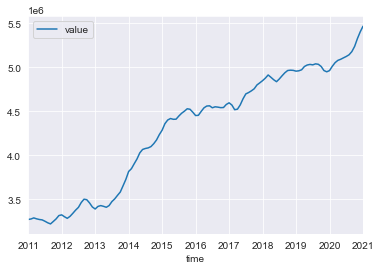

In [18]:
df_11962 = top_25_df[top_25_df['RegionName'] == 11962]

df_11962 = functions.melt_data(df_11962)

df_11962.plot()
plt.savefig('Images/df_11962');

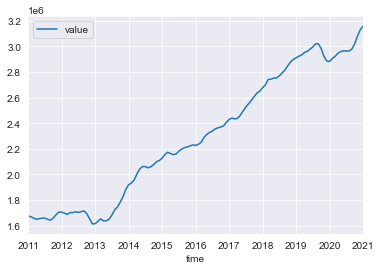

In [19]:
df_11930 = top_25_df[top_25_df['RegionName'] == 11930]

df_11930 = functions.melt_data(df_11930)

df_11930.plot()
plt.savefig('Images/df_11930');

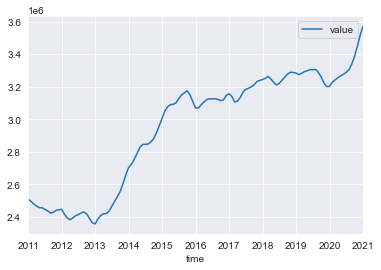

In [20]:
df_11976 = top_25_df[top_25_df['RegionName'] == 11976]

df_11976 = functions.melt_data(df_11976)

df_11976.plot()
plt.savefig('Images/df_11976');

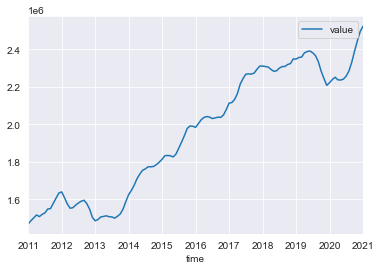

In [21]:
df_11975 = top_25_df[top_25_df['RegionName'] == 11975]

df_11975 = functions.melt_data(df_11975)

df_11975.plot()
plt.savefig('Images/df_11975');

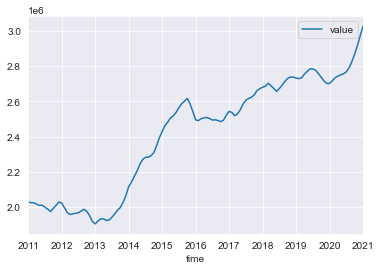

In [22]:
df_11932 = top_25_df[top_25_df['RegionName'] == 11932]

df_11932 = functions.melt_data(df_11932)

df_11932.plot()
plt.savefig('Images/df_11932');

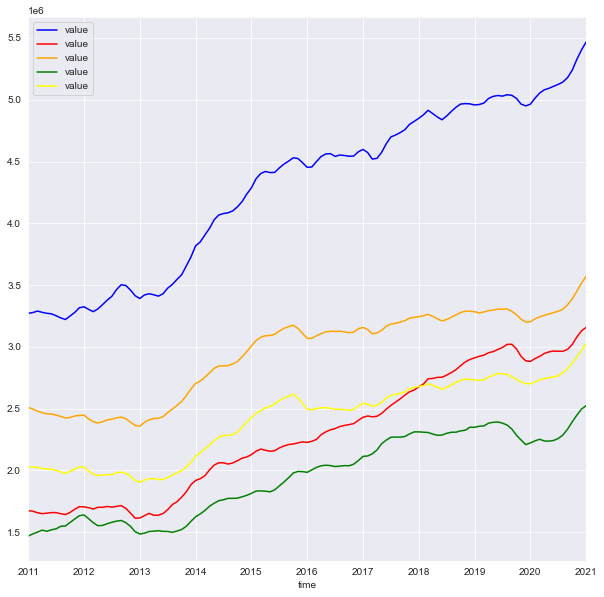

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
df_11962.plot(ax=ax, color = 'blue')
df_11930.plot(ax=ax, color = 'red')
df_11976.plot(ax=ax, color = 'orange')
df_11975.plot(ax=ax, color = 'green')
df_11932.plot(ax=ax, color = 'yellow')
plt.legend()
plt.savefig('Images/top_5')

In [24]:
# fig, ax = plt.subplots(figsize=(10,10))
# plt.bar(top_25_zip['City'], top_25_zip['10_yr_Profit'])
# plt.xticks(rotation=45, ha='right')
# plt.title('Top 25 Most Profitable by City')
# plt.ylabel('10 Yr Profit')
# plt.xlabel('City');

## Modeling

### Time Series Split

#### To start our modeling process, we begin separating our data set into 80/20 splits for our training and testing sets

In [25]:
def ts_train_test_split(df):
    
    test = pd.DataFrame()
    train = pd.DataFrame()

    tscv = TimeSeriesSplit()

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index.min():train_index.max(), :],\
                          df.iloc[test_index.min():test_index.max(), :]
    
    return train, test
    

#### The functions below split our data into training and testing sets. 

In [26]:
train_962, test_962 = ts_train_test_split(df_11962)

In [27]:
train_930, test_930 = ts_train_test_split(df_11930)

In [28]:
train_976, test_976 = ts_train_test_split(df_11976)

In [29]:
train_975, test_975 = ts_train_test_split(df_11975)

In [30]:
train_932, test_932 = ts_train_test_split(df_11932)

#### First Simple Model

#### Below we will take the baseline RMSE value from each of our 5 zip codes. We will use these values for comparison while building our models. 

In [31]:
baseline_962 = functions.get_baseline(train_962)

In [32]:
baseline_930 = functions.get_baseline(train_930)

In [33]:
baseline_976 = functions.get_baseline(train_976)

In [34]:
baseline_975 = functions.get_baseline(train_975)

In [35]:
baseline_932 = functions.get_baseline(train_932)

#### Now that we have our baselines we will move forward checking for stationarity

-----------11962-------------


(-3.836741932214261,
 0.002552991866277558,
 12,
 85,
 {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475},
 1903.1948228127007)

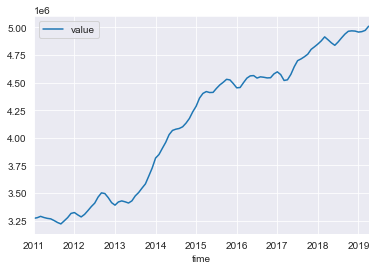

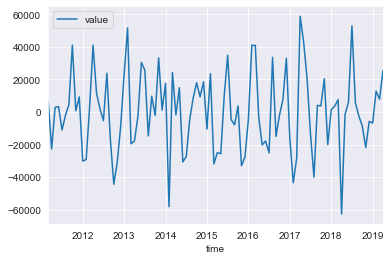

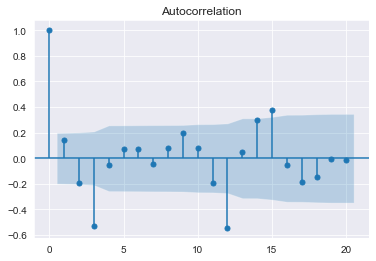

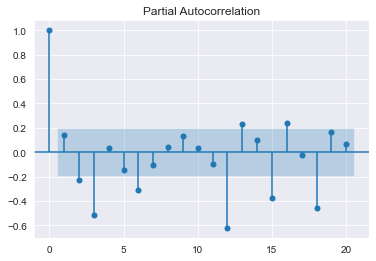

In [36]:
print('-----------11962-------------')
functions.diff_stationary_check(train_962)

-----------11930-------------


(-4.307152353259412,
 0.00043171301564452107,
 12,
 85,
 {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475},
 1811.1858123338143)

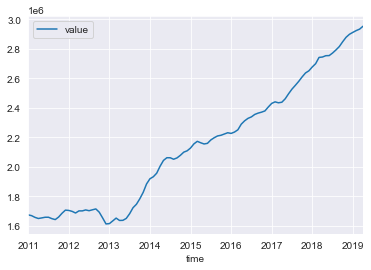

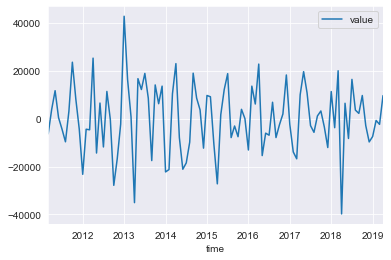

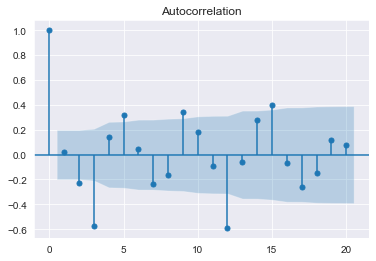

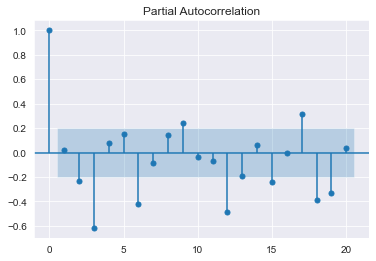

In [37]:
print('-----------11930-------------')
functions.diff_stationary_check(train_930)

-----------11976-------------


(-3.5365732075702394,
 0.007096020687649916,
 12,
 85,
 {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475},
 1816.092859021212)

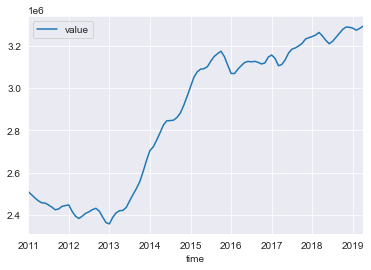

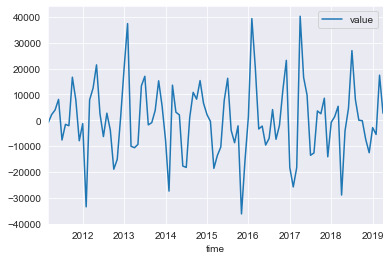

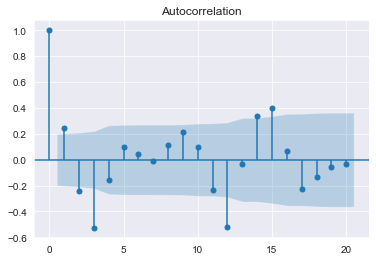

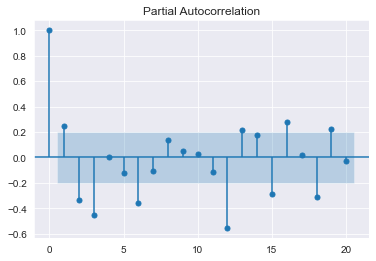

In [38]:
print('-----------11976-------------')
functions.diff_stationary_check(train_976)

-----------11975-------------


(-3.3632083036969043,
 0.012278895343860776,
 12,
 85,
 {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475},
 1817.4910529675171)

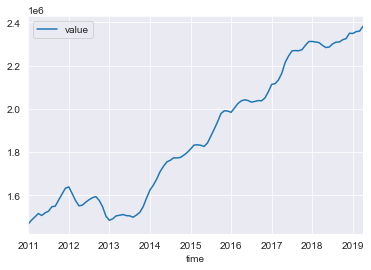

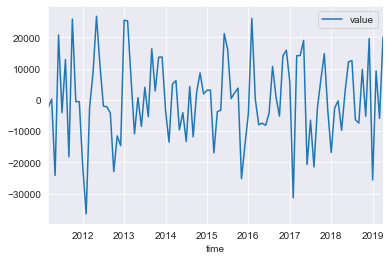

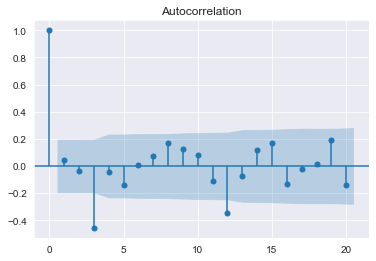

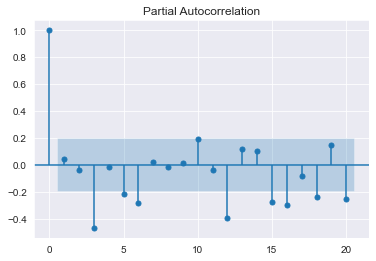

In [39]:
print('-----------11975-------------')
functions.diff_stationary_check(train_975)

-----------11932-------------


(-3.3565466044875865,
 0.01253245365533908,
 12,
 85,
 {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475},
 1816.7266426806373)

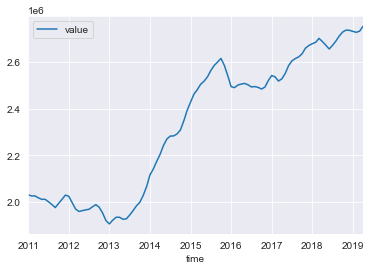

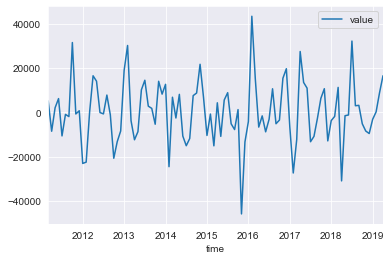

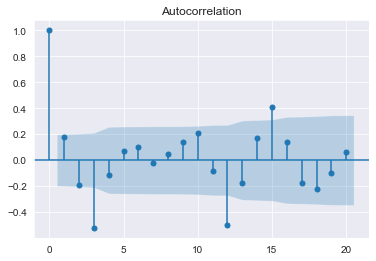

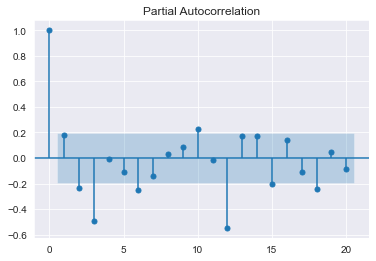

In [40]:
print('-----------11932-------------')
functions.diff_stationary_check(train_932)

#### Above we created a function to add two diffs to our data. This allowed us to gain stationarity on all of our time series data! By visualizing our ACF and PACF plots for zipcode 11962 its hard to see any form of trend. 

#### Heres are breakdown of our ACF and PACF charts above:

* 11962:
    * The ACF plot looks like we have a significance every two intervals
    * The PACF plot shows us we have significance on our second and third lag. There's almost consistency across every 3rd lag excluding one thoughout the plot.  
    
* 11930
    * The ACF plot looks like we have a significance every two or three intervals. 
    * The PACF plot shows us we have significance on every third lag. This is definitely more pronounce over 11962  
    
* 11976
    * The ACF plot looks like we have a significance on the first three lags of itself.
    * The PACF plot shows us we have significance on the first three lags. Again, there is almost consistency across every third lag as previously seen.   
    
* 11975
    * The ACF plot doesn't show us a trend excluding the yearly trend
    * The PACF plot shows consistency across every third lag  

* 11932
    * The ACF plot doesn't show us a trend excluding the yearly trend
    * The PACF plot shows consistency across every third lag  

#### Note: All plots show correlations at every 12 months

#### The ACF plot shows the significance level intervals of the auto-correlation of any series with its lagged value. This is denoted as our p value in the below modeling.

#### The PACF plot gives the partial correlation of a stationary time series with its own lagged values. this is denoted as our q value in the below modeling.

#### Below we will loop through zipcode 11962 with different p,d,q values to find the optimal parameters and see if our inclinations are correct. 

In [41]:
# # Define the p, d and q parameters to take any value between 0 and 2
# p = range(0,4)

# d = range(2,3)

# q = range(0,4)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#  # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = SARIMAX(train_962,
#                             order=comb,
#                             seasonal_order=combs,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic, output.mse])

#         except:
#             continue
            
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'mse'])
# ans_df

In [42]:
# ans_df.to_pickle('baseline_grid_search.pkl')

#### Now that we have used a grid search to find our optimal parameters we will build our model and review the RMSE based on the lowest AIC value. 

In [43]:
# ans_df.to_pickle('base_grid_search.pkl')
ans_df = pd.read_pickle('baseline_grid_search.pkl')

In [44]:
ans_df.dropna().sort_values('aic')

,pdq,pdqs,aic,mse
982,"(1, 2, 0)","(1, 2, 2, 12)",1.000000e+01,2.439025e+240
1593,"(2, 2, 1)","(0, 2, 1, 12)",1.000000e+01,6.445871e+52
1605,"(2, 2, 1)","(1, 2, 1, 12)",1.200000e+01,7.443222e+52
1617,"(2, 2, 1)","(2, 2, 1, 12)",1.400000e+01,1.929892e+54
2025,"(3, 1, 2)","(0, 2, 1, 12)",1.400000e+01,5.671988e+159
...,...,...,...,...
1729,"(3, 0, 0)","(0, 0, 1, 12)",1.758693e+06,3.785399e+16
1153,"(2, 0, 0)","(0, 0, 1, 12)",1.856064e+06,1.311642e+19
625,"(1, 0, 1)","(0, 0, 1, 12)",1.856765e+06,2.881541e+14
577,"(1, 0, 0)","(0, 0, 1, 12)",1.859466e+06,1.312224e+16


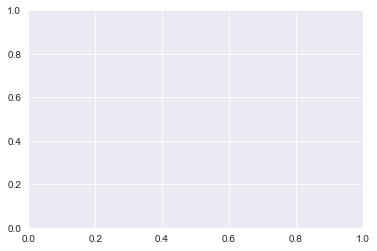

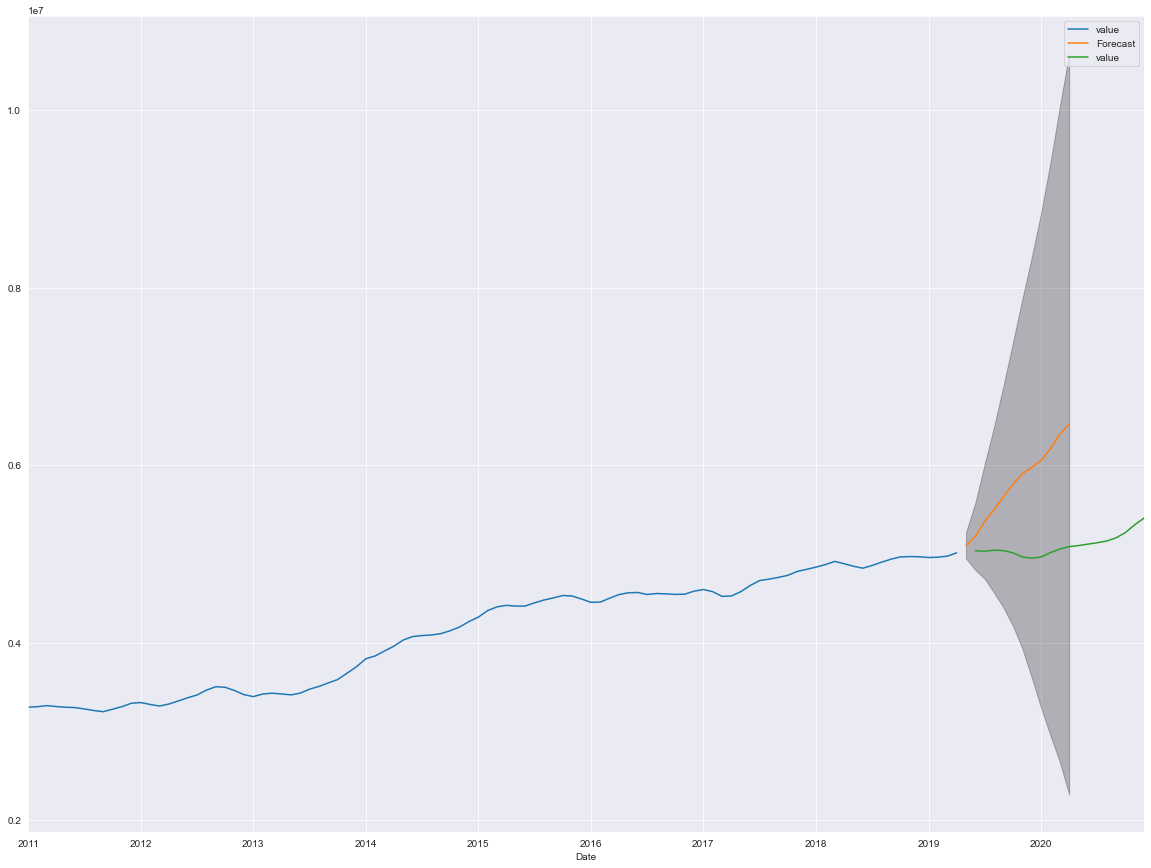

In [45]:
mod = SARIMAX(train_962,
                order=(2,2,2),
                seasonal_order=(1,2,0,12),
                enforce_stationarity=False,
                enforce_invertibility=False,
                )

output = mod.fit()
pred = output.get_prediction(dynamic=False)
pred_conf = pred.conf_int()

# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
fig, ax = plt.subplots()

ax = train_962.plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

test_962.plot(ax=ax)
ax.set_xlabel('Date')

plt.legend()
plt.show();

In [46]:
rmse_962_aic = functions.rmse(prediction, test_962)
print(rmse_962_aic)
print(baseline_962)

922487.5823884896
137444.52755841572


#### The lowest AIC performed poorly with a drastic increase in our RMSE. Let's see what happens if we filter based on MSE and use the lowest value.

In [47]:
ans_df.dropna().sort_values('mse')

,pdq,pdqs,aic,mse
1200,"(2, 0, 1)","(0, 0, 0, 12)",1783.054533,4.103165e+09
1776,"(3, 0, 1)","(0, 0, 0, 12)",1553.590397,2.003704e+10
1248,"(2, 0, 2)","(0, 0, 0, 12)",1590.355188,2.889589e+10
624,"(1, 0, 1)","(0, 0, 0, 12)",1834.747164,2.894483e+10
1152,"(2, 0, 0)","(0, 0, 0, 12)",1834.748017,2.894609e+10
...,...,...,...,...
1605,"(2, 2, 1)","(1, 2, 1, 12)",12.000000,7.443222e+52
1617,"(2, 2, 1)","(2, 2, 1, 12)",14.000000,1.929892e+54
2037,"(3, 1, 2)","(1, 2, 1, 12)",16.000000,5.105929e+159
2025,"(3, 1, 2)","(0, 2, 1, 12)",14.000000,5.671988e+159


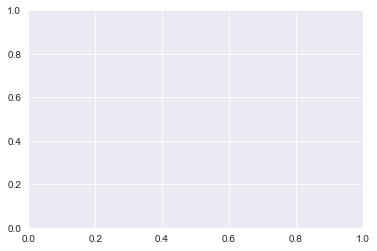

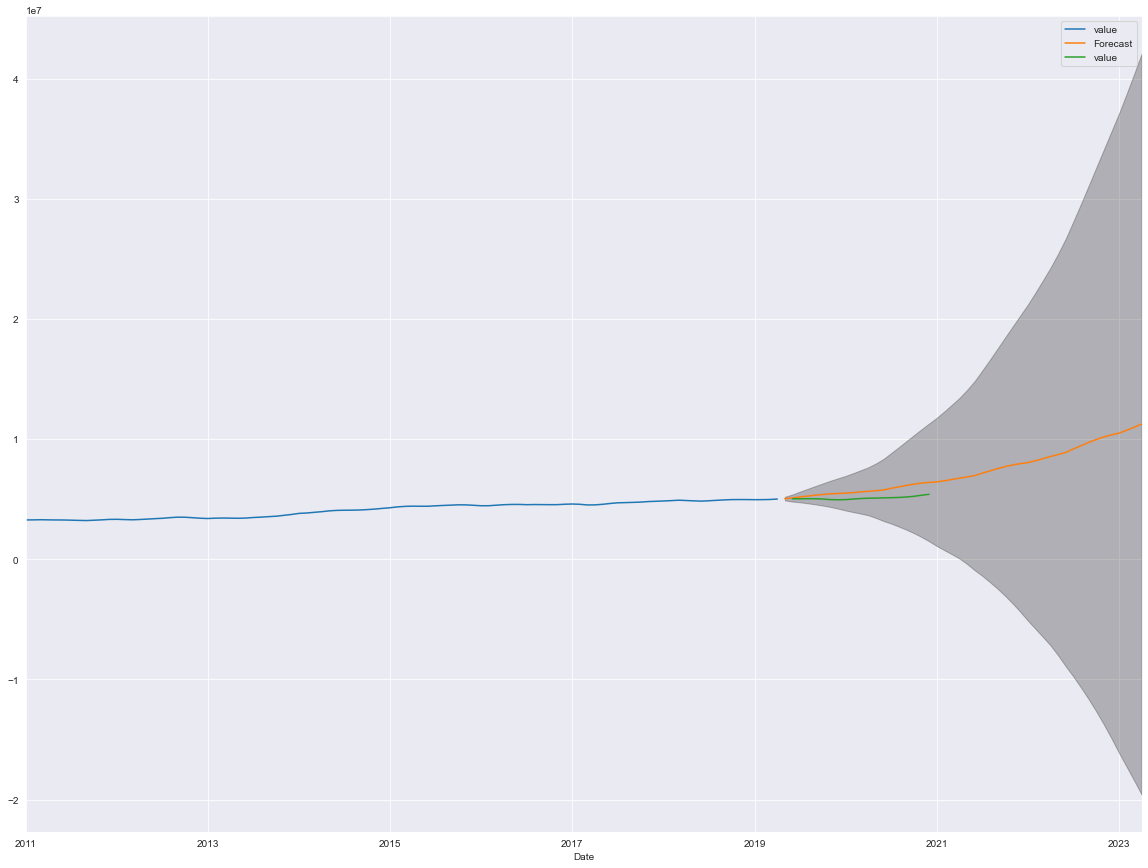

In [48]:
mod = SARIMAX(train_962,
                order=(1,2,1),
                seasonal_order=(0,2,3,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

output = mod.fit()
pred = output.get_prediction(dynamic=False)
pred_conf = pred.conf_int()

# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=48)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
fig, ax = plt.subplots()

ax = train_962.plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

test_962.plot(ax=ax)
ax.set_xlabel('Date')

plt.legend()
plt.show();

In [49]:
rmse_962_mse = functions.rmse(prediction, test_962)
print(rmse_962_mse)
print(baseline_962)

655528.6551263484
137444.52755841572


#### Our model is still showing poor results but its doing better than our model based off of AIC.

# Facebook Prophet Analysis

##### Below we will try using the Facebook Prophet to see if we get any better results.
#### To start we need to get our dataframes columns to the models liking. fbprophet requires the date column to be labeled 'ds' and the predicted column to be labeled 'y'. The below function will convert our dataframes for us. 

In [50]:
# Rename our training sets
p_train_962 = functions.prophet_rename(train_962)
p_train_930 = functions.prophet_rename(train_930)
p_train_976 = functions.prophet_rename(train_976)
p_train_975 = functions.prophet_rename(train_975)
p_train_932 = functions.prophet_rename(train_932)

# Rename our testing sets
p_test_962 = functions.prophet_rename(test_962)
p_test_930 = functions.prophet_rename(test_930)
p_test_976 = functions.prophet_rename(test_976)
p_test_975 = functions.prophet_rename(test_975)
p_test_932 = functions.prophet_rename(test_932)

#### Now we will instantiate a vanilla model and see what our results are

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


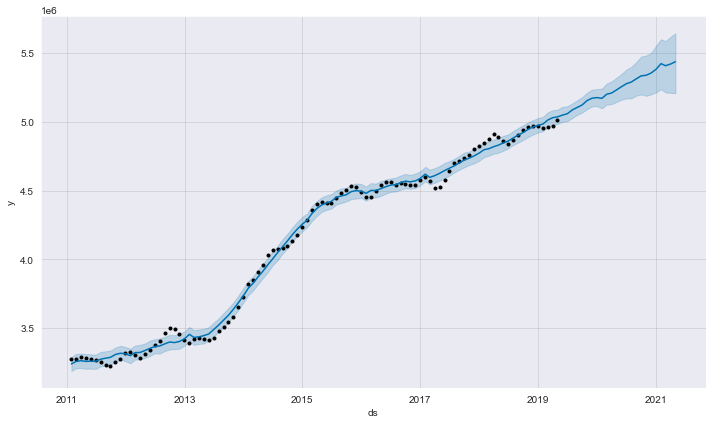

In [51]:
# Initialize our model
prophet = Prophet(yearly_seasonality=True)

prophet.fit(p_train_962)

future = prophet.make_future_dataframe(periods=24, freq='M')

forecast = prophet.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = prophet.plot(forecast)

plot_plotly(prophet, forecast)

plot_components_plotly(prophet, forecast)

pred_dynamic = output.get_prediction(dynamic=False, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

#### Below we can see our forcasting details. This doesnt tell us much as this is only using our training data. Next we will take a look at the RMSE against the testing set. 

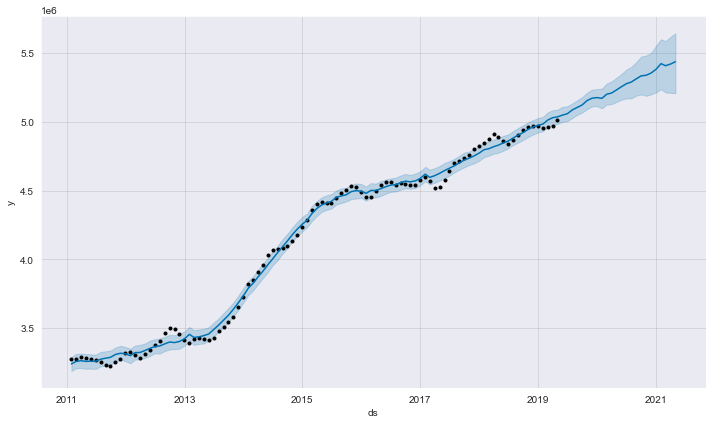

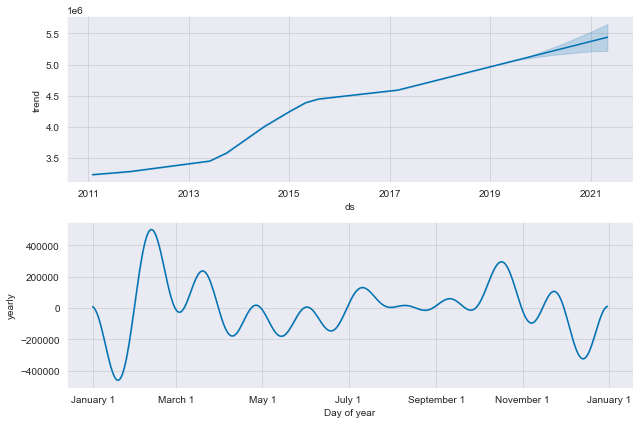

In [52]:
prophet.plot(forecast)

prophet.plot_components(forecast);

#### Below we create a dataframe that includes our testing set that we converted at the beginning of this section. Our RMSE is still substantially higher than our baseline. 

In [53]:
metric_df = forecast.set_index('ds')[['yhat']].join(p_test_930.set_index('ds')).reset_index()
metric_df.dropna(inplace=True)
print(np.sqrt(mean_squared_error(metric_df['y'], metric_df['yhat'])))
print(baseline_930)

2250246.0793240312
95676.5235135072


#### Above we can see that this is our worst model yet. 

#### Finally we will perform a grid search to try and find the optimal parameters for our model. Lets see if we can find a lower RMSE score hidden in this model. 

In [54]:
# p_930_best_params = functions.best_prophet_params(p_train_930, p_test_930)

In [56]:
# p_930_best_params

In [57]:
model_930 = Prophet(changepoint_prior_scale= 0.005,\
                    changepoint_range= 0.8,\
                    growth= 'linear',\
                    holidays_prior_scale= 0.1,\
                    n_changepoints= 10,\
                    seasonality_mode= 'additive',\
                    seasonality_prior_scale= 1,\
                    yearly_seasonality= 20)

model_930.fit(p_train_930)

future = model_930.make_future_dataframe(periods=24, freq='M')

forecast = model_930.predict(future)

# fig1 = prophet.plot(forecast)

plot_plotly(model_930, forecast)

plot_components_plotly(model_930, forecast)

pred_dynamic = output.get_prediction(dynamic=False, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


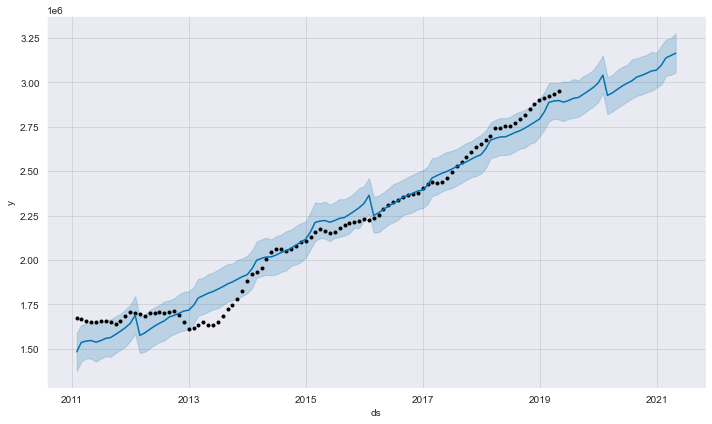

In [58]:
model_930.plot(forecast)
plt.savefig('forecast');

In [ ]:
# p_962_best_params = functions.best_prophet_params(p_train_962, p_test_962)

In [59]:
# p_962_best_params

In [60]:
model_962 = Prophet(changepoint_prior_scale= 0.005,\
                    changepoint_range= 0.8,\
                    growth= 'linear',\
                    holidays_prior_scale= 0.1,\
                    n_changepoints= 10,\
                    seasonality_mode= 'multiplicative',\
                    seasonality_prior_scale= 1,\
                    yearly_seasonality= 20)

model_962.fit(p_train_962)

future = model_962.make_future_dataframe(periods=24, freq='M')

forecast = model_962.predict(future)

# fig1 = prophet.plot(forecast)

plot_plotly(model_962, forecast)

plot_components_plotly(model_962, forecast)

pred_dynamic = output.get_prediction(dynamic=False, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


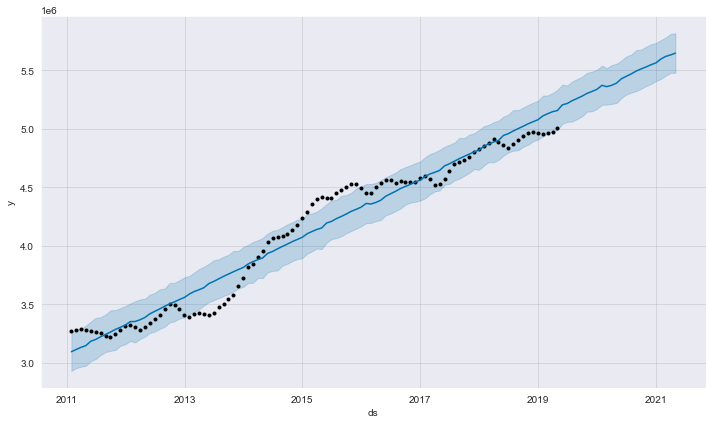

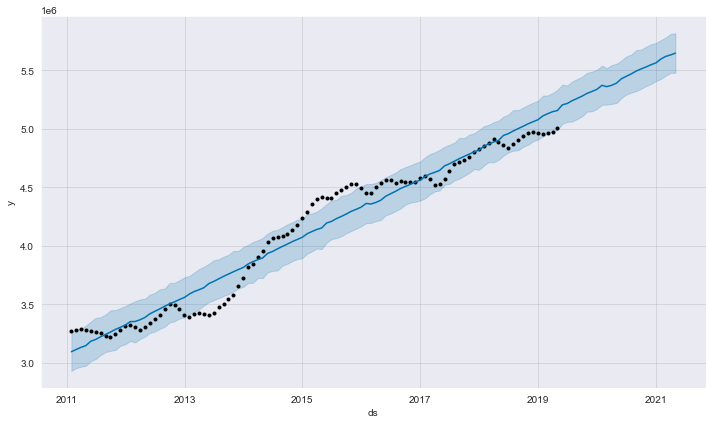

In [61]:
model_962.plot(forecast)

In [62]:
# p_976_best_params = functions.best_prophet_params(p_train_976,p_test_976)

In [63]:
# p_976_best_params

In [64]:
model_976 = Prophet(changepoint_prior_scale= 0.005,\
                    changepoint_range= 0.8,\
                    growth= 'linear',\
                    holidays_prior_scale= 0.1,\
                    n_changepoints= 10,\
                    seasonality_mode= 'multiplicative',\
                    seasonality_prior_scale= 1,\
                    yearly_seasonality= 20)

model_976.fit(p_train_976)

future = model_976.make_future_dataframe(periods=24, freq='M')

forecast = model_976.predict(future)

# fig1 = prophet.plot(forecast)

plot_plotly(model_976, forecast)

plot_components_plotly(model_976, forecast)

pred_dynamic = output.get_prediction(dynamic=False, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
# p_975_best_params = functions.best_prophet_params(p_train_975, p_test_975)

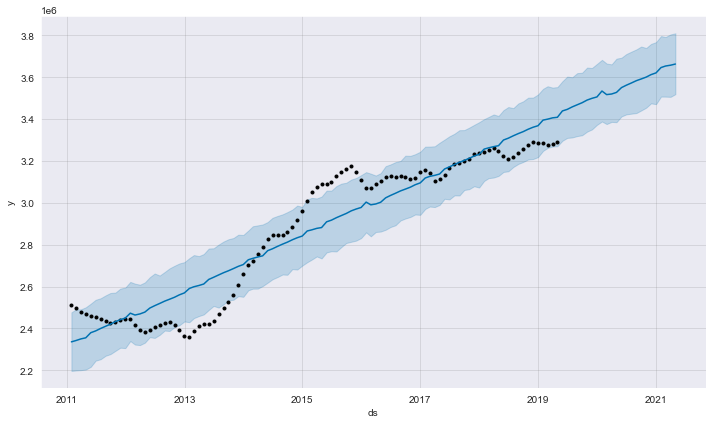

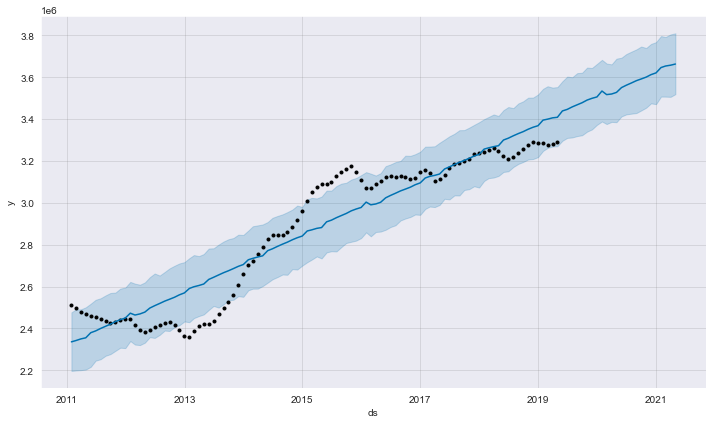

In [66]:
model_976.plot(forecast)

In [68]:
# p_975_best_params

In [69]:
model_975 = Prophet(changepoint_prior_scale= 0.005,\
                    changepoint_range= 0.8,\
                    growth= 'linear',\
                    holidays_prior_scale= 0.1,\
                    n_changepoints= 10,\
                    seasonality_mode= 'multiplicative',\
                    seasonality_prior_scale= 1,\
                    yearly_seasonality= 20)

model_975.fit(p_train_975)

future = model_975.make_future_dataframe(periods=24, freq='M')

forecast = model_975.predict(future)

# fig1 = prophet.plot(forecast)

plot_plotly(model_975, forecast)

plot_components_plotly(model_975, forecast)

pred_dynamic = output.get_prediction(dynamic=False, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
# p_932_best_params = functions.best_prophet_params(p_train_932, p_test_932)

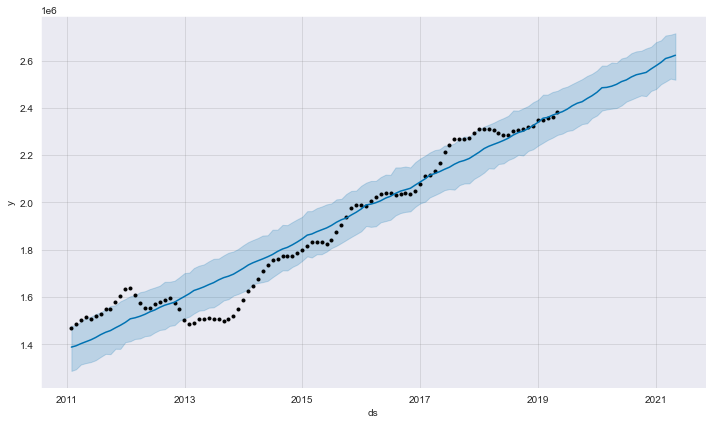

In [71]:
model_975.plot(forecast);

In [72]:
# p_932_best_params

In [73]:
model_932 = Prophet(changepoint_prior_scale= 0.005,\
                    changepoint_range= 0.8,\
                    growth= 'linear',\
                    holidays_prior_scale= 0.1,\
                    n_changepoints= 10,\
                    seasonality_mode= 'additive',\
                    seasonality_prior_scale= 1,\
                    yearly_seasonality= 20)

model_932.fit(p_train_932)

future = model_932.make_future_dataframe(periods=24, freq='M')

forecast = model_932.predict(future)

# fig1 = prophet.plot(forecast)

plot_plotly(model_932, forecast)

plot_components_plotly(model_932, forecast)

pred_dynamic = output.get_prediction(dynamic=False, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


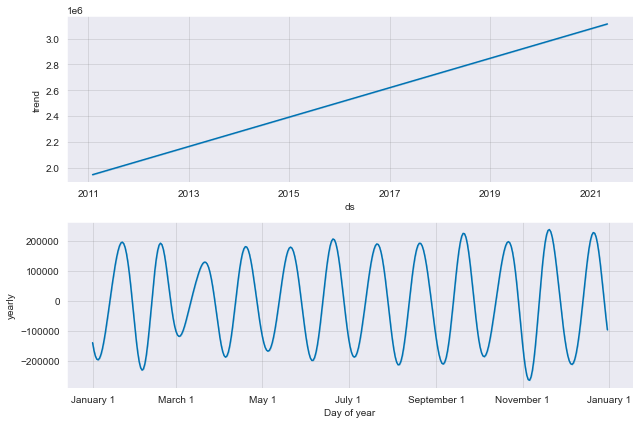

In [74]:
model_932.plot_components(forecast);

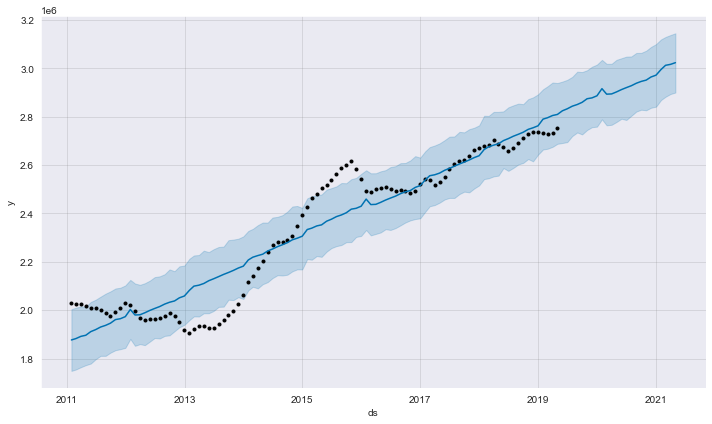

In [75]:
model_932.plot(forecast);

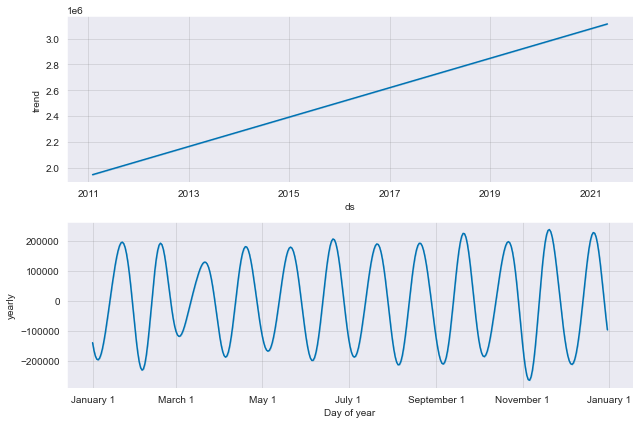

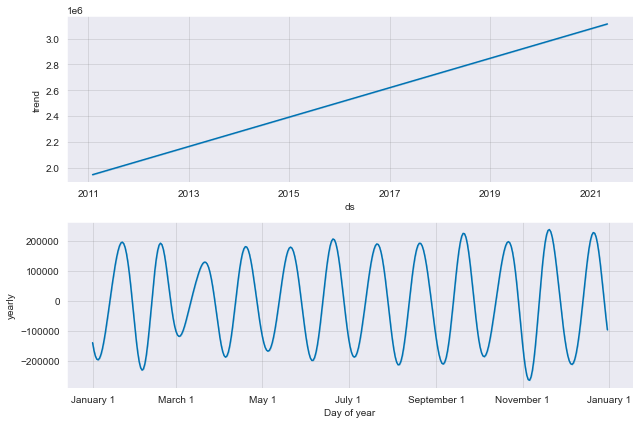

In [77]:
model_932.plot_components(forecast)

#### Conclusion: Our param grid search was able to lower the RMSE value across all of our models excluding one. Moving forward we will have to further tune this model. 